# Classification of text

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

## Dataset information

In [2]:
builder = tfds.builder("imdb_reviews")
print(builder.info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

## Features

In [3]:
builder = tfds.builder("imdb_reviews")

# Features
print(f"Features: {{0}}".format(builder.info.features))

# shape
print(f"Features shape: {{0}}".format(builder.info.features.shape))

# type of label
print(f"Label type: {{0}}".format(builder.info.features["label"].dtype))

# number of classes
print(f"Number of classes: {{0}}".format(builder.info.features["label"].num_classes))

Features: FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})
Features shape: {'text': (), 'label': ()}
Label type: <dtype: 'int64'>
Number of classes: 2


## Downloading dataset

In [4]:
ds, info = tfds.load("imdb_reviews", split="train", with_info=True, try_gcs=True)

## Displaying Text and Label

In [5]:
tfds.as_dataframe(ds.take(1), info)

,label,text
0,0 (neg),"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [6]:
(ds_train, ds_test), info = tfds.load(
    "imdb_reviews", split=["train", "test"], with_info=True, as_supervised=True
)

In [7]:
print(ds_train.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


## Text Vectorization

In [8]:
vocabulary_size = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size
)
encoder.adapt(ds_train.map(lambda text, label: text))

In [9]:
vocabulary = encoder.get_vocabulary()
print(vocabulary[:20])

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but']


In [10]:
print(len(encoder.get_vocabulary()))

1000


In [11]:
print(encoder("incredibly"))

tf.Tensor([927], shape=(1,), dtype=int64)


## Building Training Model

In [12]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

### Visualizing Model

## Training

In [14]:
(ds_train, ds_test), info = tfds.load(
    "imdb_reviews", split=["train", "test"], with_info=True, as_supervised=True
)

ds_train = ds_train.batch(128)
ds_test = ds_test.batch(128)


history = model.fit(ds_train, epochs=10, validation_data=ds_test, validation_steps=30)

Epoch 1/10
196/196 [==============================] - 63s 322ms/step - loss: 0.6842 - accuracy: 0.5019 - val_loss: 0.5997 - val_accuracy: 0.6341
Epoch 2/10
196/196 [==============================] - 60s 308ms/step - loss: 0.4856 - accuracy: 0.7404 - val_loss: 0.4229 - val_accuracy: 0.7914
Epoch 3/10
196/196 [==============================] - 60s 307ms/step - loss: 0.4005 - accuracy: 0.8178 - val_loss: 0.3746 - val_accuracy: 0.8302
Epoch 4/10
196/196 [==============================] - 60s 307ms/step - loss: 0.3622 - accuracy: 0.8428 - val_loss: 0.3532 - val_accuracy: 0.8451
Epoch 5/10
196/196 [==============================] - 60s 308ms/step - loss: 0.3374 - accuracy: 0.8551 - val_loss: 0.3360 - val_accuracy: 0.8492
Epoch 6/10
196/196 [==============================] - 60s 307ms/step - loss: 0.3219 - accuracy: 0.8624 - val_loss: 0.3273 - val_accuracy: 0.8510
Epoch 7/10
196/196 [==============================] - 60s 307ms/step - loss: 0.3130 - accuracy: 0.8668 - val_loss: 0.3231 - val_ac

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________
None


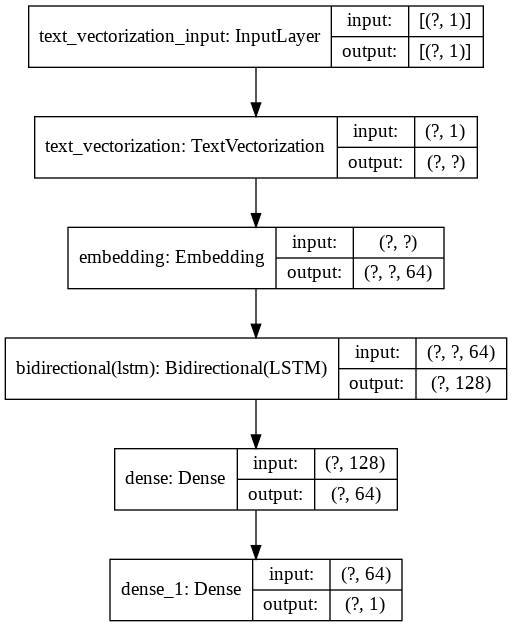

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## Visualizing the Training History

Text(0.5, 1.0, 'History of Training and Validation Accuracy across epochs')

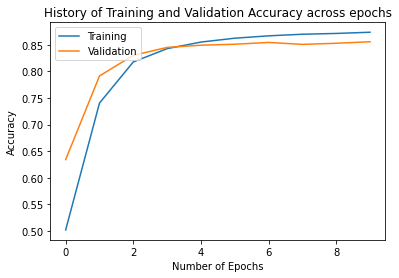

In [17]:
import matplotlib.pyplot as plot

plot.plot(history.history["accuracy"], label="Training")
plot.plot(history.history["val_accuracy"], label="Validation")
plot.legend(loc="upper left")
plot.ylabel("Accuracy")
plot.xlabel("Number of Epochs")
plot.title("History of Training and Validation Accuracy across epochs")

Text(0.5, 1.0, 'History of Training and Validation Loss across epochs')

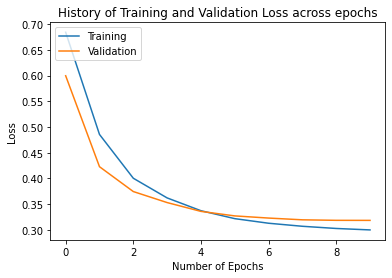

In [18]:
plot.plot(history.history["loss"], label="Training")
plot.plot(history.history["val_loss"], label="Validation")
plot.legend(loc="upper left")
plot.ylabel("Loss")
plot.xlabel("Number of Epochs")
plot.title("History of Training and Validation Loss across epochs")

## Evaluating the Model

In [19]:
loss, accuracy = model.evaluate(ds_test, verbose=0)
print(f"accuracy: {accuracy} and loss:{loss}")

accuracy: 0.8560400009155273 and loss:0.31955674290657043
